<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.8.0

numpy      : 1.19.5
scipy      : 1.3.1
pandas     : 1.3.2
matplotlib : 3.1.1
statsmodels: 0.13.0
sklearn    : 0.21.3

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Git hash: HEAD



In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
PATH_TO_DATA = '/Users/zaharsaraev/Documents/Machine_learning_coursera/Final_project/'

In [5]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(answer)

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [19]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [20]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [24]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [17]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                    facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors = 100, n_jobs = 1)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [13]:
knn.fit(X_train, y_train)
scores = cross_val_score(knn, X_train, y_train, cv = skf)
print('StratifiedKFold score on train data %f' %  round(np.mean(scores),3))
print('Score on test data %f' % round(accuracy_score(knn.predict(X_valid), y_valid),3))

StratifiedKFold score on train data 0.562000
Score on test data 0.584000


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True)
forest.fit(X_train, y_train)
print('StratifiedKFold score on train data %f' % round(cross_val_score(forest, X_train, y_train, cv=skf).mean(), 3))
print('Score on test data %f' % round(accuracy_score(forest.predict(X_valid), y_valid),3))

StratifiedKFold score on train data 0.716000
Score on test data 0.734000


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [16]:
write_answer_to_file('0.716 0.734',
                     os.path.join(PATH_TO_DATA, 'answer4_2.txt'))

In [27]:
!cat answer4_2.txt

0.716 0.734

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [9]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [18]:
logit = LogisticRegression(random_state=17)
logit.fit(X_train, y_train)
print('StratifiedKFold score on train data %f' % round(cross_val_score(logit, X_train, y_train, cv=skf).mean(), 3))
print('Score on test data %f' % round(accuracy_score(logit.predict(X_valid), y_valid),3))

StratifiedKFold score on train data 0.763000
Score on test data 0.782000


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [19]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, multi_class='multinomial', random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 54.1 s, sys: 3.12 s, total: 57.3 s
Wall time: 20.5 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [47]:
logit_mean_cv_scores1 = (np.mean(logit_grid_searcher1.scores_.get(31), axis=0))

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [23]:
cross_val_score(logit_grid_searcher1, X_train, y_train, cv=skf).mean()

0.7609235825322113

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

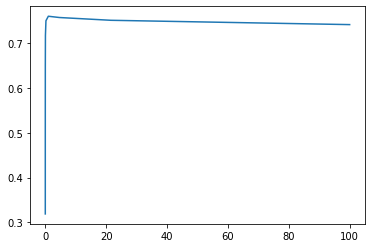

In [53]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)


**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [22]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV( Cs = logit_c_values2, multi_class='multinomial', random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 2min 7s, sys: 6.89 s, total: 2min 14s
Wall time: 46.3 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [59]:
logit_mean_cv_scores2 = (np.mean(logit_grid_searcher2.scores_.get(31), axis=0))
logit_mean_cv_scores2

array([0.73684386, 0.75797677, 0.76102512, 0.76051677, 0.76011039,
       0.76021251, 0.76082149, 0.76021235, 0.75878931, 0.75858593,
       0.7582814 , 0.75818011, 0.7578757 , 0.75777423, 0.75736775,
       0.7568594 , 0.7565544 , 0.75635165, 0.75635137, 0.75604655])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [56]:
cross_val_score(logit_grid_searcher2, X_train, y_train, cv=skf).mean()

0.7616345315365575

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

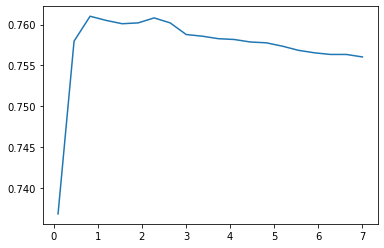

In [57]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

In [66]:
logit_mean_cv_scores2

array([0.73684386, 0.75797677, 0.76102512, 0.76051677, 0.76011039,
       0.76021251, 0.76082149, 0.76021235, 0.75878931, 0.75858593,
       0.7582814 , 0.75818011, 0.7578757 , 0.75777423, 0.75736775,
       0.7568594 , 0.7565544 , 0.75635165, 0.75635137, 0.75604655])

In [65]:
logit_c_values2

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [61]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7755392273050485

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [62]:
write_answer_to_file('0.762 0.776',
                     os.path.join(PATH_TO_DATA, 'answer4_3.txt'))

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [69]:
from sklearn.svm import LinearSVC

In [70]:
svm = LinearSVC(C = 1, random_state=17)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [16]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm,svm_params1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 39.9 s, sys: 294 ms, total: 40.2 s
Wall time: 41.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [21]:
print(svm_grid_searcher1.best_score_)
print(svm_grid_searcher1.best_params_)

0.6924405608616135
{'C': 1111.1112}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

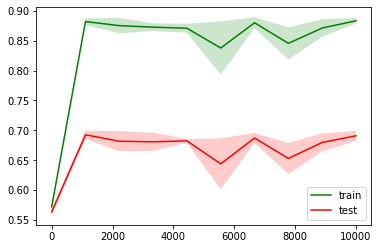

In [20]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [71]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm,svm_params2, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 11s, sys: 569 ms, total: 1min 12s
Wall time: 1min 14s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.00...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, ver

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [23]:
print(svm_grid_searcher2.best_score_)
print(svm_grid_searcher2.best_params_)

0.7649867913025807
{'C': 0.24213793103448275}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

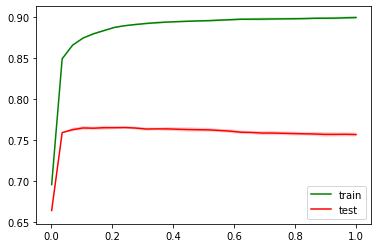

In [24]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [26]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.predict(X_valid), y_valid)

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [27]:
print('StratifiedKFold score on train data %f' % round(svm_grid_searcher2.best_score_, 3))
print('Score on test data %f' % round(svm_cv_acc,3))

StratifiedKFold score on train data 0.765000
Score on test data 0.784000


In [28]:
write_answer_to_file('0.765 0.784',
                     os.path.join(PATH_TO_DATA, 'answer4_4.txt'))

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [76]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as X_pkl:
        X = pickle.load(X_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y= pickle.load(y_pkl)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    
    clf = estimator
    clf.fit(X_train, y_train)
    
    return(cross_val_score(clf, X_train, y_train, cv=skf).mean(),
          accuracy_score(clf.predict(X_test), y_test))
    
    

**Убедитесь, что функция работает.**

In [77]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7649865831742932, 0.7835980090068737)

score совпадает -> функция работает корректно

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [29]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [51]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        args = [session_length, window_size]
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{0}_w{1}.pkl'.format(*args))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{0}_w{1}.pkl'.format(*args))
        print('Window %f' % window_size, 'Session_length %f' % session_length)
        print (model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

Window 10.000000 Session_length 15.000000
(0.8236146528931586, 0.8402465039108794)
Window 10.000000 Session_length 10.000000
(0.7649865831742932, 0.7835980090068737)
Window 7.000000 Session_length 15.000000
(0.8497839675458435, 0.8549858967977435)
Window 7.000000 Session_length 10.000000
(0.7997122815541956, 0.806703169072507)
Window 7.000000 Session_length 7.000000
(0.7512059972160369, 0.7632321221171395)
Window 5.000000 Session_length 15.000000
(0.8713555893473997, 0.8770744428639166)
Window 5.000000 Session_length 10.000000
(0.8180574733785416, 0.8279990516832622)
Window 5.000000 Session_length 7.000000
(0.7730925535908787, 0.7879326695116169)
Window 5.000000 Session_length 5.000000
(0.7244694135749855, 0.7376718824087245)
CPU times: user 36.3 s, sys: 154 ms, total: 36.4 s
Wall time: 36.6 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [52]:
write_answer_to_file('0.871 0.877',
                     os.path.join(PATH_TO_DATA, 'answer4_5.txt'))

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
     args = [session_length, window_size]
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{0}_w{1}.pkl'.format(*args))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{0}_w{1}.pkl'.format(*args))
    print('Window %f' % window_size, 'Session_length %f' % session_length)
    print (model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
write_answer_to_file('0.871 0.877',
                     os.path.join(PATH_TO_DATA, 'answer4_6.txt'))

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [6]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [7]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [25]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs =  [logit_grid_searcher2.Cs_[10]], n_jobs=-1, random_state=17, multi_class='ovr', cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 7min 3s, sys: 21.8 s, total: 7min 25s
Wall time: 4min 29s


LogisticRegressionCV(Cs=[3.7315789473684213], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [16]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, (logit_cv_150users.scores_.get(user_id)).mean()))

User 6, CV score: 0.9958605417956022
User 13, CV score: 0.9962988437657018
User 15, CV score: 0.9952144941616708
User 16, CV score: 0.9918053357013745
User 28, CV score: 0.990126289191399
User 31, CV score: 0.994494992675945
User 33, CV score: 0.9936609787358054
User 39, CV score: 0.9860497214718689
User 46, CV score: 0.9980919658794004
User 49, CV score: 0.9950791363690957
User 50, CV score: 0.9944639254428281
User 53, CV score: 0.9937132821275779
User 65, CV score: 0.9969139510553036
User 66, CV score: 0.9949329556438827
User 82, CV score: 0.9963716258753559
User 85, CV score: 0.9963093562623891
User 89, CV score: 0.9906269213247908
User 92, CV score: 0.9943907103744326
User 100, CV score: 0.9947243924629983
User 102, CV score: 0.9912421564512733
User 103, CV score: 0.9805034317559714
User 105, CV score: 0.9968931236551741
User 106, CV score: 0.9946300536046052
User 118, CV score: 0.9907833941753709
User 119, CV score: 0.9965907528972139
User 120, CV score: 0.9942657008915537
User 12

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [43]:
class_distr = np.bincount(y_train_150.astype('int'))
user_id, counts = np.unique(y_train_150, return_counts=True)
diff = []
for idx, count in zip(user_id, counts):
    diff.append((logit_cv_150users.scores_.get(idx)).mean() -  (1-count/len(y_train_150)))

In [44]:
num_better_than_default = (np.array(diff) > 0).sum()
num_better_than_default

121

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [60]:
write_answer_to_file(str(round(num_better_than_default/150, 3)),
                     os.path.join(PATH_TO_DATA, 'answer4_7.txt'))

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [65]:
y_binary_128 = [1 if x==128 else 0 for x in y_150users]

In [66]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [74]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_150users)

CPU times: user 10min 46s, sys: 6.63 s, total: 10min 52s
Wall time: 11min 10s


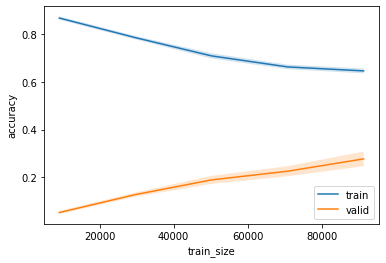

In [75]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.